# packages

In [84]:
library(tidyverse)
library(readxl)
library(writexl)
library(sjmisc)
library(pheatmap)
library(Seurat)
library(paletteer)

library(patchwork)
library(ggrepel)
library(repr)

library(org.Mm.eg.db)
library(GSEABase)
library(clusterProfiler)
library(enrichplot)

library(future)
plan("multisession", workers = 10)
options(future.globals.maxSize = 3e9)
options(Seurat.object.assay.version = "v5")

# load data

In [86]:
scdata = readRDS("/data2/xiangwei/projects/zhaolian/10polyIntegrate/results/sctAnnotationSeuObj")

In [87]:
scdata
head(scdata@meta.data)

An object of class Seurat 
50442 features across 45620 samples within 2 assays 
Active assay: SCT (22704 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 8 dimensional reductions calculated: pca, umap.unintegrated, integrated.cca, integrated.rpca, integrated.harmony, umap.cca, umap.rpca, umap.harmony

,nCount_RNA,nFeature_RNA,sampleID,percent.mt,Phase,sampleType,sampleTypeFine,nCount_SCT,nFeature_SCT,unintegrated_clusters,seurat_clusters,cca_cluster,rpca_cluster,harmony_cluster,main,fine
,<dbl>,<dbl>,<fct>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
WT_1.bcHTXJ,5633,2155,WT1,3.586011,G1,normal,WT1,2575,1386,8,10,16,10,10,Epithelial,Epi-Krt20
WT_1.bcHGRE,10487,3855,WT1,5.912082,G2M,normal,WT1,2180,1408,8,11,0,9,11,Epithelial,Epi-Srgn
WT_1.bcHIFA,9429,3137,WT1,6.352742,G2M,normal,WT1,2197,1152,8,10,16,10,10,Epithelial,Epi-Krt20
WT_1.bcHFJN,7902,2746,WT1,7.884080,G1,normal,WT1,2205,1178,8,10,16,10,10,Epithelial,Epi-Krt20
WT_1.bcGOTP,7605,3330,WT1,4.865220,S,normal,WT1,2136,1383,20,0,11,22,0,Neutrophil,Neutrophil
WT_1.bcFBTL,8837,2901,WT1,6.551997,G1,normal,WT1,2213,1189,8,10,3,10,10,Epithelial,Epi-Krt20


# deg early vs normal

In [88]:
table(scdata$sampleType)


normal  tumor 
  2619  43001 

In [90]:
npvalue=read_xlsx("/data2/xiangwei/projects/zhaolian_old/BfinalSample/Np_new2.xlsx")%>% select(sampleID,Np,`1/Np`) %>% 
mutate(stage=if_else(Np>3,"early","late"))%>%as.data.frame()

In [91]:
npvalue=npvalue%>%select(sampleID,stage)

In [92]:
wtsample=c("WT1","WT2")
wtstage=c("normal","normal")
wttable=tibble(sampleID=wtsample,stage=wtstage)

In [93]:
npvalue=rbind(npvalue,wttable)

In [ ]:
npvalue

In [95]:
cellID=colnames(scdata)

In [96]:
scdata@meta.data=scdata@meta.data%>%left_join(npvalue,by = "sampleID")

In [97]:
rownames(scdata@meta.data)=cellID

In [98]:
cellNum = as.data.frame.array(table(scdata$stage,scdata$main))
cellNum

,Neutrophil,Epithelial,Macrophage,T,B,Endothelial,Mast,Fibroblast
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
early,4390,14253,5451,3373,980,301,349,103
late,2754,3017,4924,1289,825,476,363,153
normal,11,2284,41,202,65,4,10,2


In [20]:
scdata$celltype_stage = paste(scdata$main, scdata$stage, sep = "_")

In [ ]:
celltypeStage=names(table(scdata$celltype_stage))
celltypeStage

In [ ]:
celltypeEarly=celltypeStage[str_detect(celltypeStage,"early")]
celltypeEarly

In [ ]:
celltypeLate=celltypeStage[str_detect(celltypeStage,"late")]
celltypeLate

In [ ]:
celltypeNormal=celltypeStage[str_detect(celltypeStage,"normal")]
celltypeNormal

In [ ]:
celltype=str_sub(celltypeLate,start = 1,end = -6)
celltype
celltype=str_c(celltype,"early_vs_normal",sep = "_")
celltype

In [25]:
scdata = PrepSCTFindMarkers(scdata)

Found 11 SCT models. Recorrecting SCT counts using minimum median counts: 2231



In [26]:
Idents(scdata)="celltype_stage"

In [30]:
epiEarlyNormal=FindMarkers(scdata, ident.1 = celltypeEarly[3], ident.2 = celltypeNormal[3])
epiEarlyNormal = epiEarlyNormal %>% rownames_to_column(var="geneID")%>% mutate(cellType= celltype[3])%>% arrange(-avg_log2FC)

In [31]:
head(epiEarlyNormal)

,geneID,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cellType
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,AY036118,0.000000e+00,15.94943,0.956,0.00,0.000000e+00,Epithelial_early_vs_normal
2,Gm10076,0.000000e+00,13.77918,0.832,0.00,0.000000e+00,Epithelial_early_vs_normal
3,Rps12,0.000000e+00,13.20606,0.796,0.00,0.000000e+00,Epithelial_early_vs_normal
4,Cmss1,0.000000e+00,13.05587,0.985,0.01,0.000000e+00,Epithelial_early_vs_normal
5,Rpl9-ps6,0.000000e+00,12.21543,0.633,0.00,0.000000e+00,Epithelial_early_vs_normal
6,Mt4,2.152676e-105,11.48047,0.178,0.00,4.887435e-101,Epithelial_early_vs_normal


In [32]:
write_xlsx(epiEarlyNormal,"results/epiEarlyNormal.xlsx")

# rm WT

In [4]:
scdata =subset(scdata, sampleID %in% c("WT1","WT2"),invert=T)

In [5]:
scdata$sampleID=as.character(scdata$sampleID)
table(scdata$sampleID)


  132_T1   142_T2 142_T5-4   148_T1   148_T3   151_T4    17_T4    18_T3 
    4387     4389     4879     5110     3812     5141     7870     5304 
   18_T4 
    2109 

In [6]:
cellID=colnames(scdata)

## Np

In [5]:
npvalue=read_xlsx("/data2/xiangwei/projects/zhaolian_old/BfinalSample/Np_new2.xlsx")%>% select(sampleID,Np,`1/Np`) %>% 
mutate(stage=if_else(Np>3,"early","late"))%>%as.data.frame()

In [6]:
#npvalue=npvalue[-1,]
npvalue

sampleID,Np,1/Np,stage
<chr>,<dbl>,<dbl>,<chr>
148_T1,1.604244,0.62334657,late
148_T3,2.670790,0.37442101,late
142_T5-4,2.802020,0.35688537,late
132_T1,4.075022,0.24539743,early
142_T2,5.653750,0.17687375,early
18_T3,6.088663,0.16423968,early
18_T4,9.575361,0.10443470,early
17_T4,11.891945,0.08409053,early
151_T4,32.589013,0.03068519,early


## add metadata

In [10]:
scdata@meta.data=scdata@meta.data%>%left_join(npvalue,by = "sampleID")

In [11]:
rownames(scdata@meta.data)=cellID

In [12]:
scdata$sampleID=factor(scdata$sampleID,levels = c('148_T1','148_T3','142_T5-4','132_T1',
                                                    '142_T2','18_T3','18_T4','17_T4','151_T4'
                                                              ))

In [13]:
table(scdata$stage,scdata$sampleID)

       
        148_T1 148_T3 142_T5-4 132_T1 142_T2 18_T3 18_T4 17_T4 151_T4
  early      0      0        0   4387   4389  5304  2109  7870   5141
  late    5110   3812     4879      0      0     0     0     0      0

In [14]:
mainColor=paletteer_d("basetheme::clean")[c(1:8)]
fineColor=paletteer_d("ggsci::default_ucscgb")

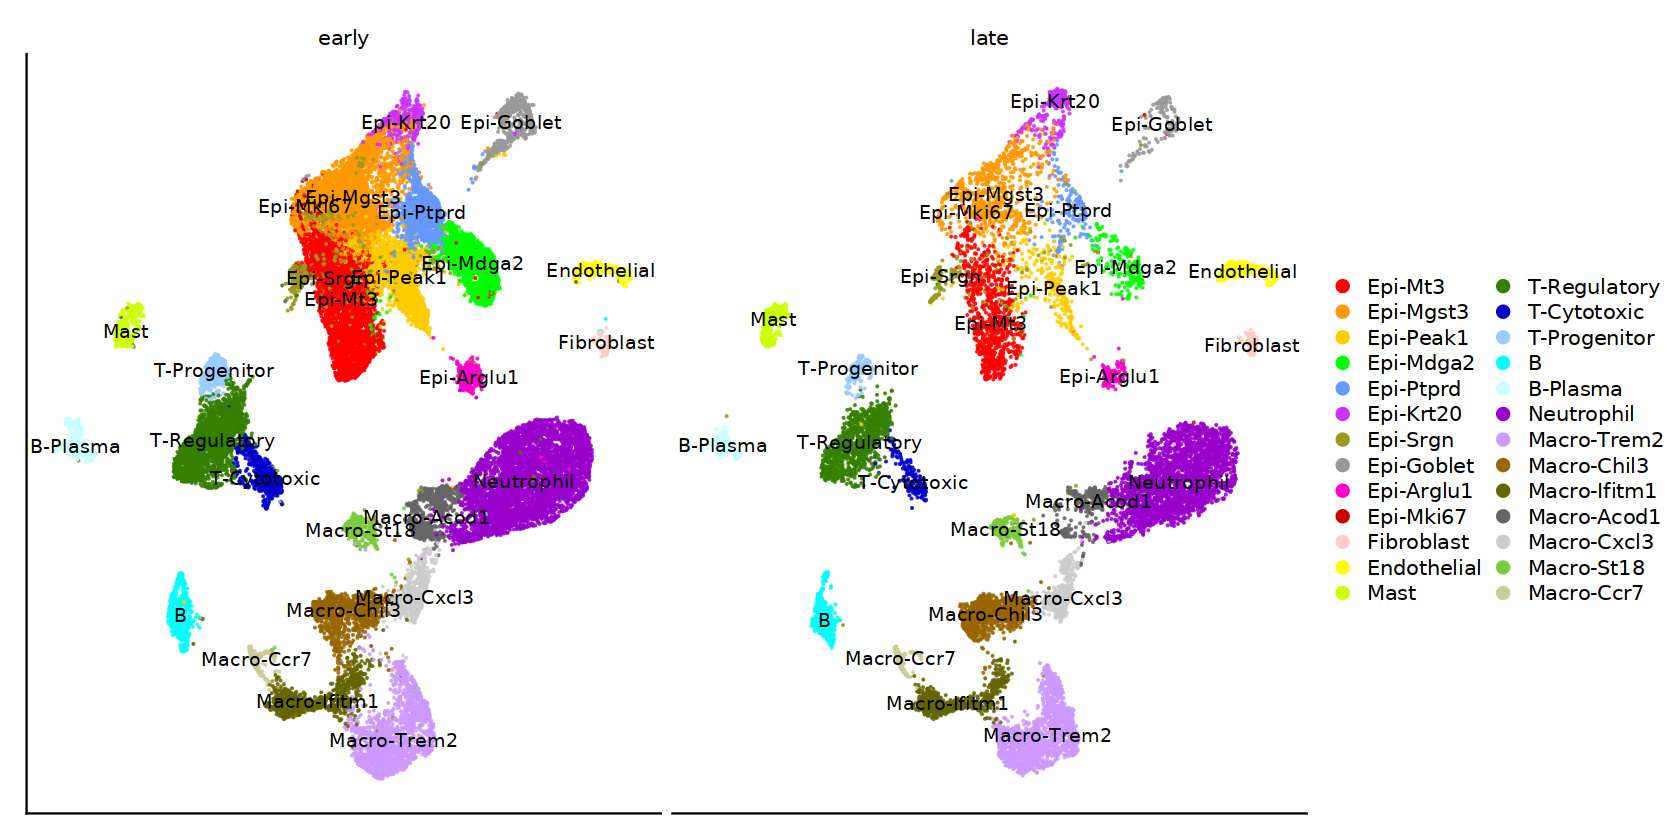

In [18]:
options(repr.plot.width=14,repr.plot.height=7)
umapfine=DimPlot(scdata,reduction = "umap.harmony",
  group.by = c( "fine"), split.by=c("stage"),label = T,order=F,pt.size=0.1,cols=fineColor,alpha=0.8)+
labs(x = NULL, y = NULL)+
theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), 
      axis.text.x = element_blank(), axis.ticks.x = element_blank())+
theme(plot.title = element_blank())
umapfine

In [20]:
ggsave(umapfine,filename = "results/plot/early_lateUMAP.pdf",width = 10,height = 4)

# main DEGS

In [21]:
cellNum = as.data.frame.array(table(scdata$stage,scdata$main))
cellNum

,Neutrophil,Epithelial,Macrophage,T,B,Endothelial,Mast,Fibroblast
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
early,4390,14253,5451,3373,980,301,349,103
late,2754,3017,4924,1289,825,476,363,153


In [22]:
scdata$celltype_stage = paste(scdata$main, scdata$stage, sep = "_")

In [ ]:
celltypeStage=names(table(scdata$celltype_stage))
celltypeStage

In [ ]:
celltypeEarly=celltypeStage[str_detect(celltypeStage,"early")]
celltypeEarly

In [ ]:
celltypeLate=celltypeStage[str_detect(celltypeStage,"late")]
celltypeLate

In [ ]:
celltype=str_sub(celltypeLate,start = 1,end = -6)
celltype

In [ ]:
celltype=str_c(celltype,"late_vs_early",sep = "_")
celltype

In [28]:
scdata = PrepSCTFindMarkers(scdata)

Found 9 SCT models. Recorrecting SCT counts using minimum median counts: 2894



In [29]:
Idents(scdata)="celltype_stage"

In [33]:
DegF=function(x){
markers = FindMarkers(scdata, ident.1 = celltypeLate[x], ident.2 = celltypeEarly[x],min.pct = 0.2)
markers = markers %>% rownames_to_column(var="geneID")%>% mutate(cellType= celltype[x])%>% arrange(-avg_log2FC)   
}

In [34]:
mainLateVsEarly=map_dfr(seq_along(celltypeLate),DegF)

In [35]:
head(mainLateVsEarly)
dim(mainLateVsEarly)

,geneID,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cellType
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Mcpt2,1.210355e-88,3.778167,0.515,0.113,2.747989e-84,B_late_vs_early
2,Tpsb2,3.412378e-42,3.605940,0.235,0.027,7.747462e-38,B_late_vs_early
3,Mcpt1,6.679137e-87,3.325063,0.550,0.148,1.516431e-82,B_late_vs_early
4,Cxcl2,3.560637e-50,2.821687,0.394,0.097,8.084070e-46,B_late_vs_early
5,Myc,3.156240e-17,2.649267,0.217,0.086,7.165928e-13,B_late_vs_early
6,Cebpb,2.525927e-52,2.595190,0.425,0.122,5.734864e-48,B_late_vs_early


[1] 14453     7

In [36]:
write_xlsx(mainLateVsEarly,"results/mainLateVsEarly.xlsx")

In [2]:
mainLateVsEarly=read_xlsx("results/mainLateVsEarly.xlsx")

## plot

In [97]:
mainLateVsEarly=mainLateVsEarly%>%rename(verse=cellType)

In [98]:
sigData=mainLateVsEarly %>% mutate(regulate=as.factor(ifelse(p_val_adj<0.05 & abs(avg_log2FC)>0.5,
                                                            ifelse(avg_log2FC>0,"Up","Down") ,
                                                            "background")))%>%
filter(regulate!="background")
sigData$regulate=factor(sigData$regulate,levels = c("Up","Down"))
#topGene
topGene=sigData%>%group_by(verse,regulate)%>% top_n(5,abs(avg_log2FC))
dbar = sigData %>% 
  group_by(verse) %>% 
  summarise(degsNum=n(),
           avg_log2FCmax=max(avg_log2FC),
           avg_log2FCmin=min(avg_log2FC))

In [99]:
sigData=sigData%>%filter(!geneID%in%topGene$geneID)

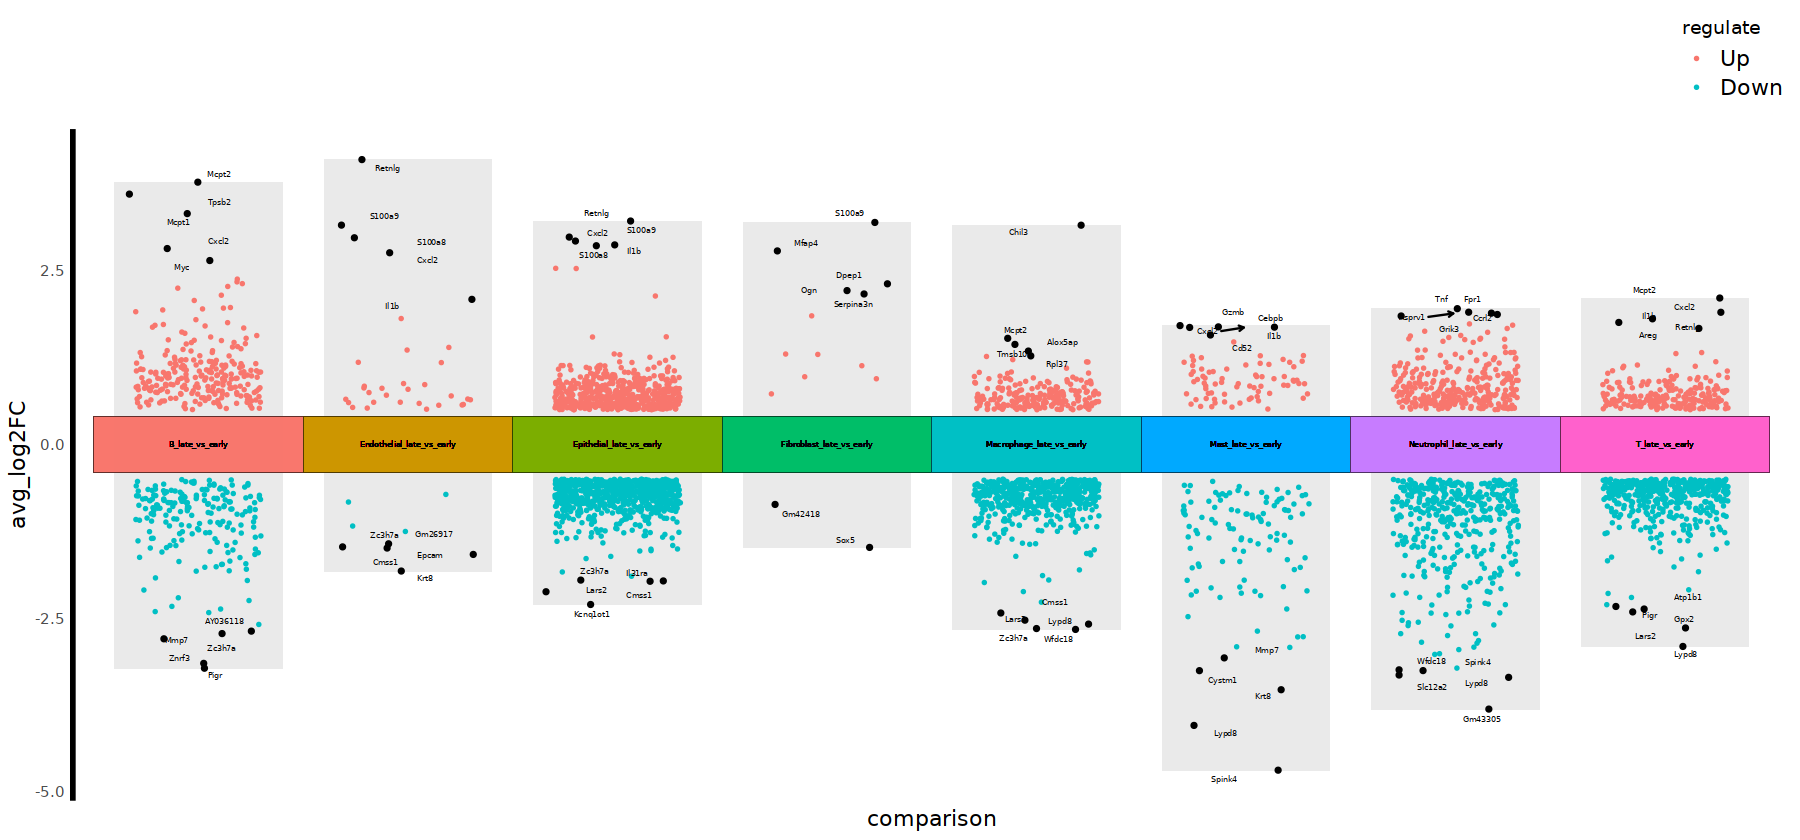

In [127]:
options(repr.plot.width=15)
Volcano=ggplot()+
  geom_col(data = dbar,  
           mapping = aes(x = verse,y = avg_log2FCmin),
           fill = "#dcdcdc",alpha = 0.6, width = 0.8)+
  geom_col(data = dbar, 
           mapping = aes(x = verse,y = avg_log2FCmax),
           fill = "#dcdcdc",alpha = 0.6, width = 0.8)+
  geom_jitter(data = sigData, 
              aes(x = verse, y = avg_log2FC, color = regulate),
              size = 0.5,
              width =0.3)+
  geom_jitter(data = topGene, 
              aes(x = verse, y = avg_log2FC),
              size = 1,
              width =0.35)+
  geom_text_repel(data = topGene,
                  aes(x = verse, y = avg_log2FC, label = geneID),
                  size = 1.5, 
                  max.overlaps = getOption("ggrepel.max.overlaps", default = 15),
                  color = 'black',
                  force = 1.2,
                  arrow = arrow(length = unit(0.008, "npc"),
                                type = "open", ends = "last"))+
  geom_tile(data = topGene, 
            aes(x = verse,
                y = 0,
                fill = verse),
            height=0.8,
            color = "black",
            alpha = 0.6,
            show.legend = F)+
  geom_text(data=topGene, 
            aes(x=verse, 
                y=0, 
                label=verse),
            size = 1.5,fontface="plain",
            color ="black")+
  labs(x="comparison", y="avg_log2FC") +
  theme_minimal() +
  theme(axis.title = element_text(size = 13,color = "black"),
    axis.line.y = element_line(color = "black",size = 1.2),
    axis.line.x = element_blank(),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    legend.position = "top",
    legend.direction = "vertical",
    legend.justification = c(1,0),
    legend.text = element_text(size = 13))
Volcano

In [128]:
ggsave(Volcano,filename = "results/plot/volMain.pdf",width = 8,height = 4)

# Epi early vs late

In [98]:
markers = FindMarkers(scdata, ident.1 = "Epithelial_early", ident.2 = "Epithelial_late", min.pct = 0.01)
markers = markers %>% rownames_to_column(var="geneID")%>% mutate(cellType= "Epithelial")%>% arrange(-avg_log2FC)

In [99]:
head(markers)
dim(markers)

,geneID,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cellType
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Syce1,1.039881e-10,5.521472,0.014,0.000,2.360946e-06,Epithelial
2,Ralyl,7.737384e-10,5.381973,0.013,0.000,1.756696e-05,Epithelial
3,Hormad2,3.875045e-37,5.211132,0.055,0.002,8.797903e-33,Epithelial
4,Galnt14,7.095778e-12,4.448754,0.017,0.001,1.611025e-07,Epithelial
5,Caln1,9.236985e-10,4.270883,0.015,0.001,2.097165e-05,Epithelial
6,Pknox2,1.043876e-09,3.808680,0.015,0.001,2.370016e-05,Epithelial


[1] 10700     7

In [100]:
markers%>%filter(geneID%in%c("Cdh1","Lamc2","Itga1","Itgb2"))

geneID,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cellType
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Itga1,7.539385e-20,1.4523298,0.073,0.028,1.711742e-15,Epithelial
Lamc2,5.877602e-22,0.5838987,0.222,0.143,1.334451e-17,Epithelial
Cdh1,3.677464e-62,0.5335067,0.659,0.503,8.349315e-58,Epithelial
Itgb2,6.426828e-39,-2.1573013,0.016,0.054,1.459147e-34,Epithelial


In [101]:
markers=markers%>%filter(p_val_adj<0.05)
dim(markers)

[1] 5118    7

In [111]:
write_xlsx(markers,"results/DEGspct0.01.xlsx")

In [2]:
markers=read_xlsx("results/DEGspct0.01.xlsx")

# valcano

In [41]:
markers=as.data.frame(markers)
rownames(markers)=markers$geneID

In [42]:
volcano_table=markers %>% mutate(regulate=case_when(p_val_adj<0.05&avg_log2FC>1 ~ "up",
                                                 p_val_adj<0.05&avg_log2FC<(-1) ~ "down",
                                                 TRUE ~ "ns")) %>% 
  mutate(label=case_when(regulate=="up"&(-log(p_val_adj,base=50)>75|avg_log2FC>1.2)~ as.character(row.names(.)),
                         regulate=="down"&(-log(p_val_adj,base=50)>75|avg_log2FC<(-5))~ as.character(row.names(.)),
                         TRUE ~ ""))
volcano_table$regulate=factor(volcano_table$regulate,levels = c("up","down","ns"))

Warning message:
“ggrepel: 326 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


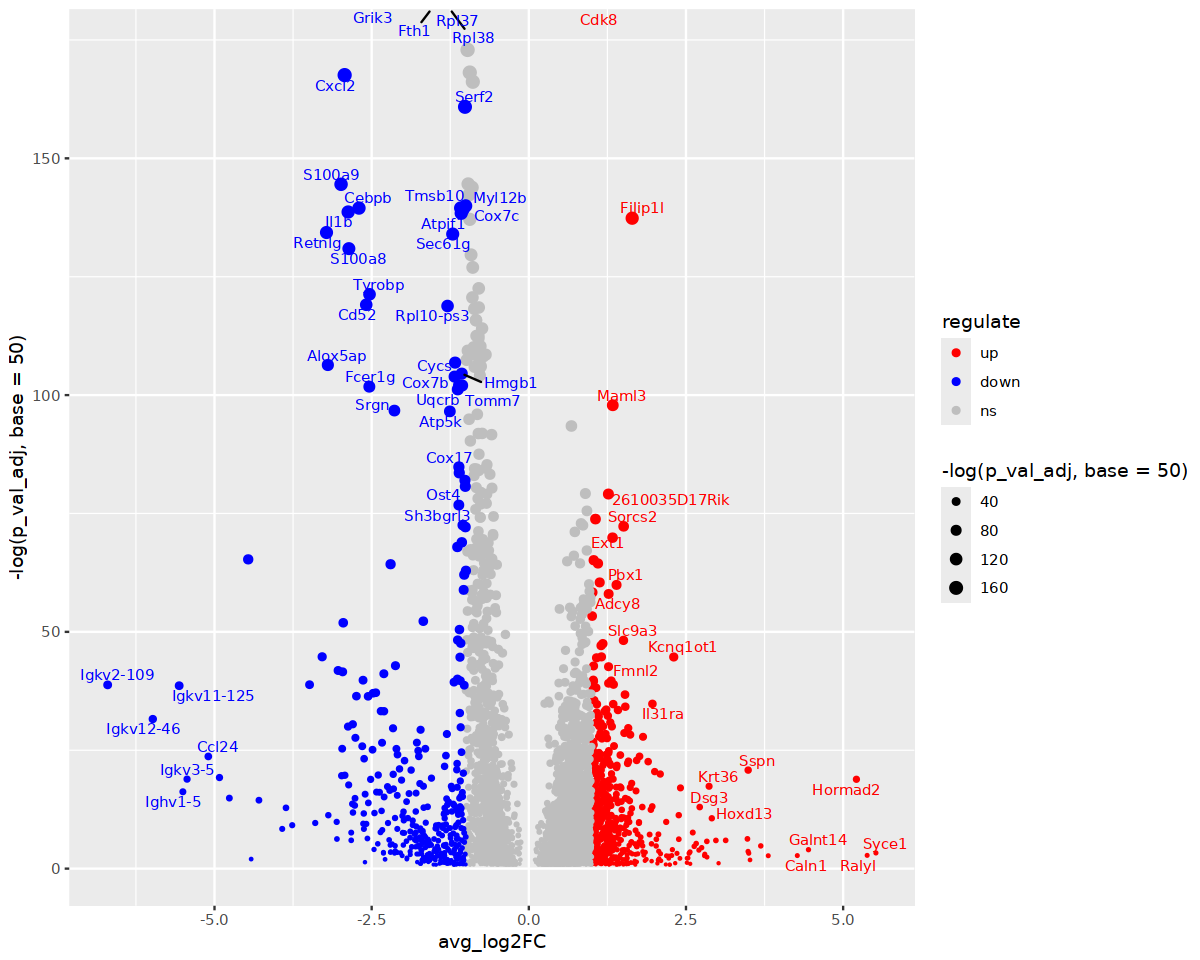

In [43]:
options(repr.plot.width=10,repr.plot.height=8)
p_vol=ggplot(volcano_table,aes(avg_log2FC,-log(p_val_adj,base=50),colour=regulate,fill=regulate))+
  scale_color_manual(values = c("red","blue","grey"))+
  geom_point(aes(size=-log(p_val_adj,base=50)))+
  scale_size_continuous(range = c(0.05,3))+
  geom_text_repel(aes(avg_log2FC,-log(p_val_adj,base=50),label=label),size=3,
                  box.padding = unit(0.1,"line"),
                  point.padding = unit(0.1,"line"),
                  segment.color="black",
                  show.legend = F)
p_vol

In [22]:
ggsave(p_vol,filename = "results/plot/vol.pdf",width = 10,height = 8)

Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


In [44]:
volcano_table=volcano_table%>%mutate(label=case_when(rownames(volcano_table) %in% c("Itga1","Lamc1","Itga2","Lamb2",
                                                                       "Itga3","Lama5","Lamc2","Itga6",
                                                                       "Lama3","Dag1","Cdh1","Itgb6",
                                                                       "Itgb4","Lamb3","Itgb1") ~as.character(row.names(.)),
                                       TRUE ~ NA ))

In [ ]:
table(volcano_table$label)
table(is.na(volcano_table$label))

In [46]:
ECM=if_else(is.na(volcano_table$label),"non-ECM","ECM")
volcano_table$ECM=ECM

In [47]:
volcano_table$ECM=factor(volcano_table$ECM,levels = c("ECM","non-ECM"))

In [48]:
table(ECM)

ECM
    ECM non-ECM 
     15    5103 

Warning message:
“Removed 5103 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


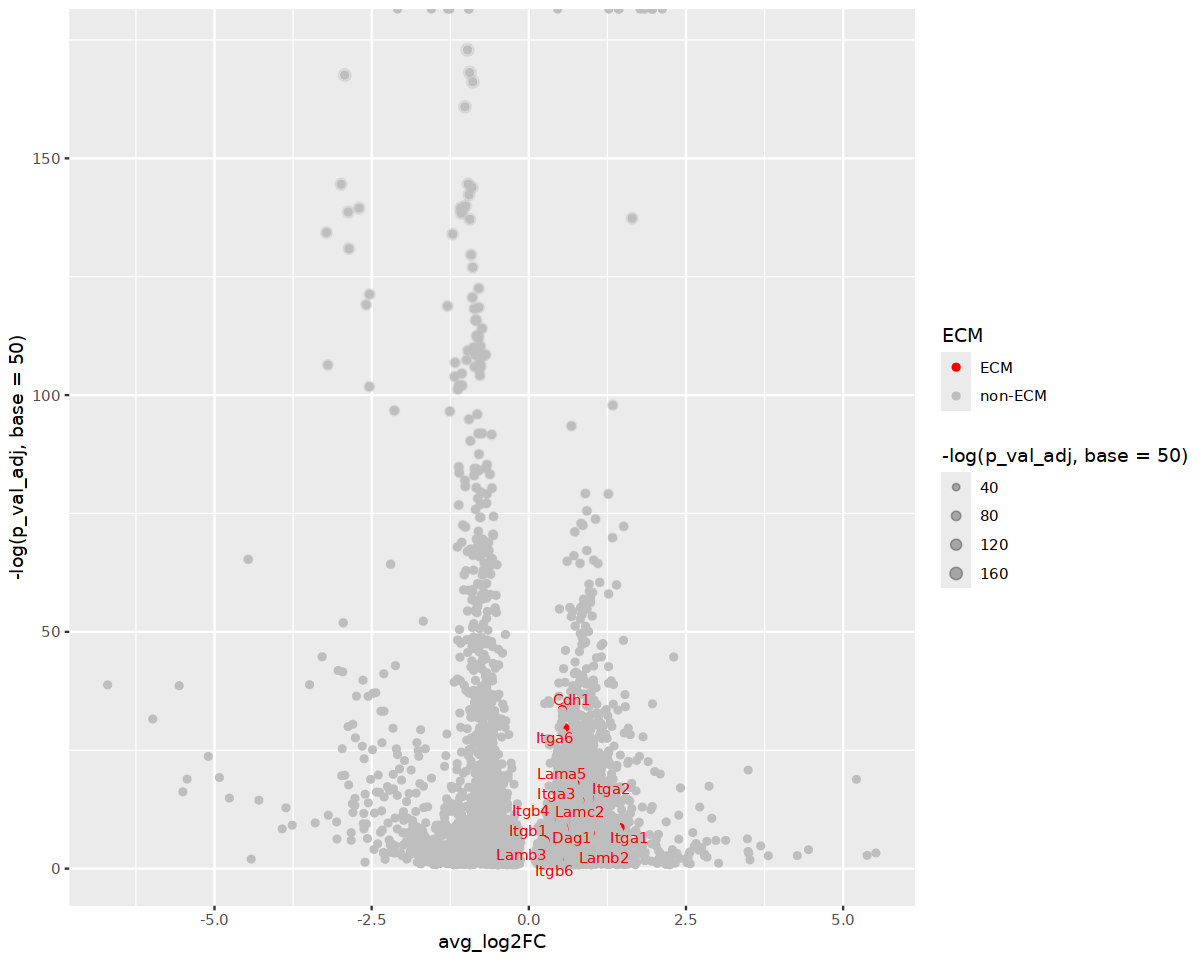

In [49]:
options(repr.plot.width=10,repr.plot.height=8)
p_vol=ggplot(volcano_table,aes(avg_log2FC,-log(p_val_adj,base=50),colour=ECM,fill=ECM))+
  scale_color_manual(values = c("red","grey"))+
  geom_point(aes(size=-log(p_val_adj,base=50)),alpha=0.3)+geom_jitter()+
  scale_size_continuous(range = c(0.05,3))+
  geom_text_repel(aes(avg_log2FC,-log(p_val_adj,base=50),label=label),size=3,
                  box.padding = unit(0.1,"line"),
                  point.padding = unit(0.1,"line"),
                  segment.color="black",
                  show.legend = F)
p_vol

In [ ]:
ggsave(p_vol,filename = "results/plot/vol_ECMgene.pdf",width = 10,height = 8)

In [4]:
ALLgmt=read.gmt("/data2/xiangwei/xiangwei/ref/GSEA/mouse/mh.all.v2023.1.Mm.symbols.gmt")

In [5]:
geneLogfc=markers$avg_log2FC

In [6]:
names(geneLogfc)=markers$geneID

In [8]:
gsea=GSEA(geneLogfc,TERM2GENE = ALLgmt,eps = 0) 
gsea_df=as.data.frame(gsea)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.78% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



In [23]:
write_xlsx(gsea_df,"results/mainEpiEarlyVsLateHMPathway.xlsx")

In [25]:
dim(gsea_df)

[1] 21 11

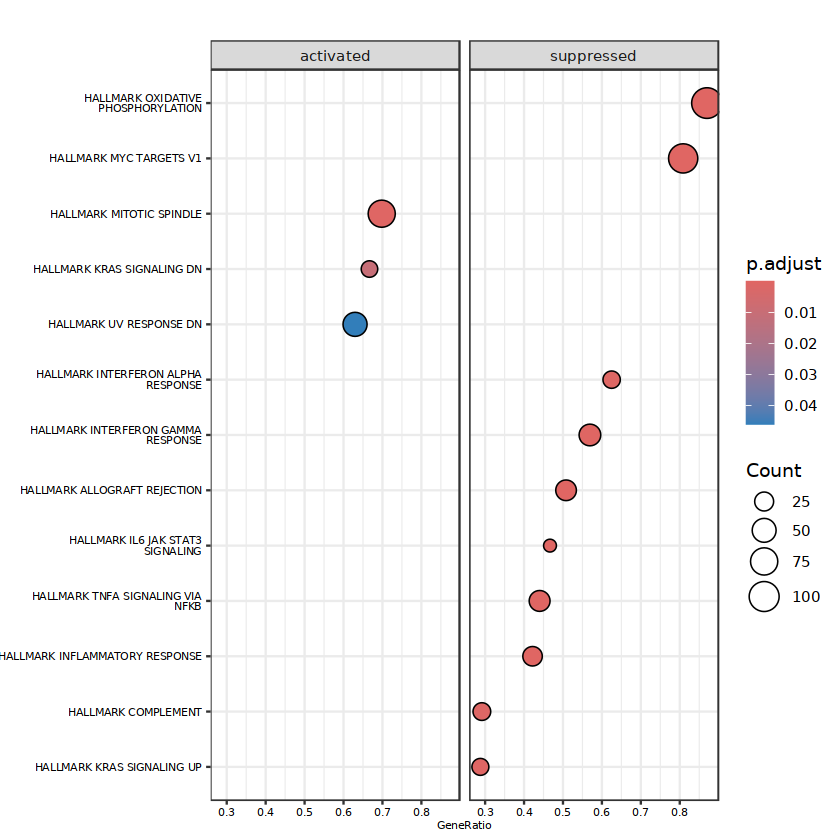

In [9]:
gseabubble=dotplot(gsea,showCategory=10,split=".sign",font.size = 6)+facet_grid(~.sign)
gseabubble

In [56]:
ggsave(gseabubble,filename = "results/plot/hallmarkerPW.pdf",width = 10,height = 8)

In [77]:
gsea_df=read_xlsx("results/mainEpiEarlyVsLateHMPathway.xlsx")
dim(gsea_df)

[1] 21 11

In [78]:
gsea_df=gsea_df%>%filter(! ID %in% c("HALLMARK_ALLOGRAFT_REJECTION","HALLMARK_COMPLEMENT"))
dim(gsea_df)

[1] 19 11

In [79]:
gsea_df=gsea_df%>%mutate(adjNES=-1*NES)

In [80]:
gsea_df=gsea_df%>%arrange(adjNES)

In [81]:
gsea_df$ID=factor(gsea_df$ID,levels = gsea_df$ID)

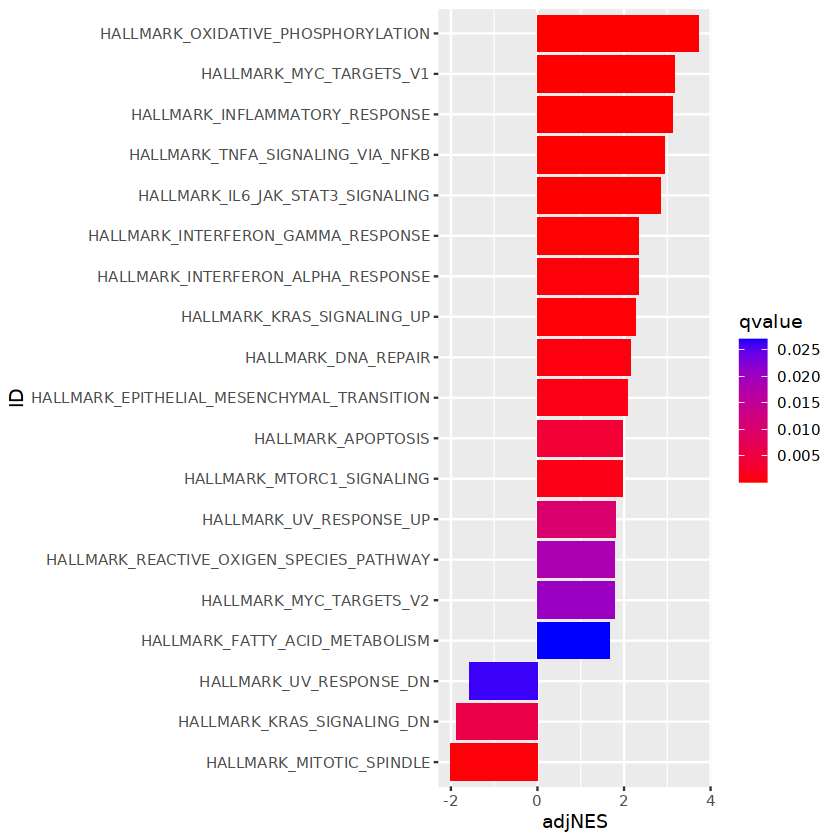

In [82]:
gseaBarplot=ggplot(gsea_df)+geom_bar(aes(adjNES,ID,fill =qvalue),stat = "identity")+ scale_fill_continuous(low = "red",
                          high = "blue")
gseaBarplot

In [83]:
ggsave(gseaBarplot,filename = "results/plot/gseaBarplot.pdf",width = 10,height = 3.5)